# Quantile-quantile (QQ) scaled climate projections

In [1]:
import glob
import calendar
import sys
import gc

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
import dask.diagnostics
import cmdline_provenance as cmdprov
#from dask.distributed import Client, LocalCluster
import dask

from calc_adjustment import read_data
from apply_adjustment import check_units

In [2]:
dask.diagnostics.ProgressBar().register()

In [3]:
#cluster = LocalCluster()
#client = Client(cluster)

In [4]:
#client

In [5]:
# Parameters
variable = 'tasmax'
obs_name = 'AGCD'
model_name = 'ACCESS1-3'
future_scenario = 'rcp45'
model_run = 'r1i1p1'

historical_time_bounds = ['1986-01-01', '2005-12-31']
future_time_bounds = ['2021-01-01', '2040-12-31']

spatial_selection = [-44, -39.5, 143.5, 149]
spatial_aggregation = "none"

example_point = [-42.9, 147.3]
example_month = 6

output_units = 'C'
model_units = None

mapping_method = 'additive'

output_file = '/g/data/wp00/dbi599/tasmax_day_AGCD-ACCESS1-3_rcp45_r1i1p1_20210101-20401231.nc'

In [6]:
# Observations 
agcd_var_names = {'tasmax': 'tmax'}
agcd_units = {'tasmax': 'C'}
if obs_name == 'AGCD':
    obs_var = agcd_var_names[variable]
    obs_units = agcd_units[variable]
else:
    obs_var = variable
    obs_units = None

# Model
model_var = variable
    
# Spatial selection    
if spatial_selection and (spatial_aggregation=="none"):
    if len(spatial_selection) == 2:
        model_spatial_selection = spatial_selection
    else:
        model_spatial_selection = None
else:
    model_spatial_selection = spatial_selection

In [7]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'obs_name' in locals(), "Must provide the name of an observational dataset"
assert 'variable' in locals(), "Must provide a variable name"

## Read data

In [8]:
hist_files = ['/g/data/rr3/publications/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/day/atmos/day/r1i1p1/latest/tasmax/tasmax_day_ACCESS1-3_historical_r1i1p1_19750101-19991231.nc',
              '/g/data/rr3/publications/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/day/atmos/day/r1i1p1/latest/tasmax/tasmax_day_ACCESS1-3_historical_r1i1p1_20000101-20051231.nc']

In [9]:
ds_hist = read_data(
    hist_files,
    model_var,
    time_bounds=historical_time_bounds,
    spatial_sel=model_spatial_selection,
    spatial_agg=spatial_aggregation,
    input_units=model_units,
    output_units=output_units)
ds_hist[model_var]

<xarray.DataArray 'tasmax' (time: 7305, lat: 145, lon: 192)>
dask.array<truediv, shape=(7305, 145, 192), dtype=float32, chunksize=(7305, 145, 20), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1986-01-01T12:00:00 ... 2005-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Maximum Near-Surface Air Temperature
    units:             °C
    cell_methods:      time: maximum
    cell_measures:     area: areacella
    history:           2012-04-03T11:23:29Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [10]:
ds_hist = ds_hist.compute()

[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.0s


In [11]:
future_files = ['/g/data/rr3/publications/CMIP5/output1/CSIRO-BOM/ACCESS1-3/rcp45/day/atmos/day/r1i1p1/latest/tasmax/tasmax_day_ACCESS1-3_rcp45_r1i1p1_20060101-20301231.nc',
                '/g/data/rr3/publications/CMIP5/output1/CSIRO-BOM/ACCESS1-3/rcp45/day/atmos/day/r1i1p1/latest/tasmax/tasmax_day_ACCESS1-3_rcp45_r1i1p1_20310101-20551231.nc']

In [12]:
ds_future = read_data(
    future_files,
    model_var,
    time_bounds=future_time_bounds,
    spatial_sel=model_spatial_selection,
    spatial_agg=spatial_aggregation,
    input_units=model_units,
    output_units=output_units)
ds_future[model_var]

<xarray.DataArray 'tasmax' (time: 7305, lat: 145, lon: 192)>
dask.array<truediv, shape=(7305, 145, 192), dtype=float32, chunksize=(7305, 145, 20), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01T12:00:00 ... 2040-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Maximum Near-Surface Air Temperature
    units:             °C
    cell_methods:      time: maximum
    cell_measures:     area: areacella
    history:           2012-04-03T07:15:04Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [13]:
ds_future = ds_future.compute()

[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s


In [14]:
obs_files = glob.glob('/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_*.nc')
obs_files.sort()

In [15]:
obs_files[76:96]

['/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1986.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1987.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1988.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1989.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1990.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1991.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1992.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1993.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1994.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1995.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1996.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1997.nc',
 '/g/data/zv2/ag

In [16]:
ds_obs = read_data(
    obs_files[76:96],
    obs_var,
    time_bounds=historical_time_bounds,
    spatial_sel=spatial_selection,
    spatial_agg=spatial_aggregation,
    input_units=obs_units,
    output_units=output_units
)

In [17]:
#ds_obs[obs_var] = ds_obs[obs_var].chunk({'lon': 20})

In [18]:
ds_obs[obs_var]

<xarray.DataArray 'tmax' (time: 7305, lat: 91, lon: 111)>
dask.array<where, shape=(7305, 91, 111), dtype=float32, chunksize=(7305, 91, 20), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1986-01-01T09:00:00 ... 2005-12-31T09:00:00
  * lat      (lat) float32 -44.0 -43.95 -43.9 -43.85 ... -39.6 -39.55 -39.5
  * lon      (lon) float32 143.5 143.5 143.6 143.6 ... 148.9 148.9 149.0 149.0
Attributes:
    cell_methods:                  time: maximum
    units:                         °C
    analysis_version_number:       3.51
    long_name:                     Daily maximum air temperature
    number_of_stations_reporting:  564
    standard_name:                 air_temperature
    frequency:                     daily
    length_scale_for_analysis:     250.0
    grid_mapping:                  crs
    coverage_content_type:         physicalMeasurement
    valid_range:                   [-100.  100.]

In [19]:
lat_min_obs = ds_obs['lat'].values.min()
lat_max_obs = ds_obs['lat'].values.max()
lon_min_obs = ds_obs['lon'].values.min()
lon_max_obs = ds_obs['lon'].values.max()

In [20]:
print(lat_min_obs, lat_max_obs, lon_min_obs, lon_max_obs)

-44.0 -39.5 143.5 149.0


In [21]:
#da_obs = da_obs.compute()

## Quantile mapping

In [22]:
mapping_methods = {'additive': '+', 'multiplicative': '*'}
qq_mapping = sdba.EmpiricalQuantileMapping.train(
    ds_future[model_var],
    ds_hist[model_var],
    nquantiles=100,
    group="time.month",
    kind=mapping_methods[mapping_method]
)
if 'lat' in qq_mapping.ds.dims:
    qq_mapping.ds = qq_mapping.ds.assign_coords({'lat': ds_future['lat'], 'lon': ds_future['lon']}) #xclim strips lat/lon attributes
    qq_mapping.ds = qq_mapping.ds.transpose('quantiles', 'month', 'lat', 'lon')
qq_mapping.ds['quantiles'] = qq_mapping.ds['quantiles'] * 100

In [23]:
qq_mapping.ds['hist_q']

<xarray.DataArray 'hist_q' (quantiles: 100, month: 12, lat: 145, lon: 192)>
array([[[[-38.428303  , -38.428303  , -38.428303  , ..., -38.43791   ,
          -38.43791   , -38.43791   ],
         [-36.13462   , -36.175594  , -36.21674   , ..., -36.038162  ,
          -36.047894  , -36.081913  ],
         [-34.474724  , -34.58518   , -34.686855  , ..., -34.1397    ,
          -34.24661   , -34.354946  ],
         ...,
         [-44.312366  , -44.458073  , -44.319454  , ..., -44.505104  ,
          -44.490253  , -44.52079   ],
         [-44.656048  , -44.619354  , -44.58426   , ..., -44.740673  ,
          -44.74135   , -44.70418   ],
         [-45.678635  , -45.678635  , -45.678635  , ..., -45.678635  ,
          -45.678635  , -45.678635  ]],

        [[-52.620335  , -52.620335  , -52.620335  , ..., -52.630325  ,
          -52.630325  , -52.630325  ],
         [-49.923244  , -49.900505  , -49.90401   , ..., -49.968742  ,
          -49.957073  , -49.940044  ],
         [-48.606358  , -48.696457  , -48.774315  , ..., -48.137913  ,
          -48.411777  , -48.488678  ],
...
         [ -1.1593618 ,  -1.1834512 ,  -1.2558604 , ...,  -1.9967953 ,
           -1.7421654 ,  -1.3741004 ],
         [ -1.669021  ,  -1.6024957 ,  -1.4854436 , ...,  -1.9236939 ,
           -1.8536013 ,  -1.7492938 ],
         [ -4.4266367 ,  -4.4266367 ,  -4.4266367 , ...,  -4.4266367 ,
           -4.4266367 ,  -4.4266367 ]],

        [[-15.657446  , -15.657446  , -15.657446  , ..., -15.664917  ,
          -15.664917  , -15.664917  ],
         [-13.767874  , -13.851628  , -13.939852  , ..., -13.538868  ,
          -13.6094675 , -13.6868305 ],
         [-13.593059  , -13.680081  , -13.750788  , ..., -13.200896  ,
          -13.335243  , -13.458674  ],
         ...,
         [ -2.09315   ,  -2.0187578 ,  -1.9444193 , ...,  -2.9840226 ,
           -2.4430454 ,  -2.1707497 ],
         [ -2.2684085 ,  -2.227102  ,  -2.2209551 , ...,  -2.3242927 ,
           -2.3222916 ,  -2.2949572 ],
         [ -3.8773735 ,  -3.8773735 ,  -3.8773735 , ...,  -3.8773735 ,
           -3.8773735 ,  -3.8773735 ]]]], dtype=float32)
Coordinates:
  * quantiles  (quantiles) float32 0.5 1.5 2.5 3.5 4.5 ... 96.5 97.5 98.5 99.5
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:     Model quantiles
    long_name:         Quantiles of model on the reference period
    units:             °C
    cell_methods:      time: maximum
    cell_measures:     area: areacella
    history:           2012-04-03T11:23:29Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [41]:
def quantile_month_plot(da, cmap=None, diverging=False, point=None):
    """Create two dimensional month/quantile plot"""

    fig, ax = plt.subplots(figsize=[16, 6])
    if 'lat' in da.dims:
        example_lat, example_lon = example_point
        point_selection = {'lat': example_lat, 'lon': example_lon}
    else:
        point_selection = {}
    quantiles = da.sel(point_selection, method='nearest')
    if diverging:
        abs_max = np.max(np.abs(quantiles.values))
        vmax = abs_max
        vmin = -1 * abs_max
    else:
        vmin = vmax = None
    quantiles.transpose('month', 'quantiles').plot(cmap=cmap, vmax=vmax, vmin=vmin)
    yticks = np.arange(1,13)
    ytick_labels = [calendar.month_abbr[i] for i in yticks]
    plt.yticks(yticks, ytick_labels)
    ax.invert_yaxis()
    plt.show()

In [36]:
def quantile_spatial_plot(
    da, month, lat_bounds=None, lon_bounds=None, example_point=None, cmap=None, diverging=False,
):
    """Spatial plot of the 10th, 50th and 90th percentile"""
    
    da_selection = da.sel({'quantiles': [10, 50, 90], 'month': month}, method='nearest')
    if lat_bounds:
        lat_min_obs, lat_max_obs = lat_bounds
        da_selection = da_selection.sel(lat=slice(lat_min_obs, lat_max_obs))
    if lon_bounds:
        lon_min_obs, lon_max_obs = lon_bounds
        da_selection = da_selection.sel(lon=slice(lon_min_obs, lon_max_obs))
    if diverging:
        abs_max = np.max(np.abs(da_selection.values))
        vmax = abs_max
        vmin = -1 * abs_max
    else:
        vmin = vmax = None
    p = da_selection.plot(
        col='quantiles',
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        figsize=[20, 5.5],
        subplot_kws={'projection': ccrs.PlateCarree(),},
        vmax=vmax,
        vmin=vmin,
    )
    for ax in p.axes.flat:
        ax.coastlines()
        if example_point:
            lat, lon = example_point
            ax.plot(lon, lat, 'go', zorder=5, transform=ccrs.PlateCarree())
    plt.suptitle(calendar.month_name[month])
    plt.show()

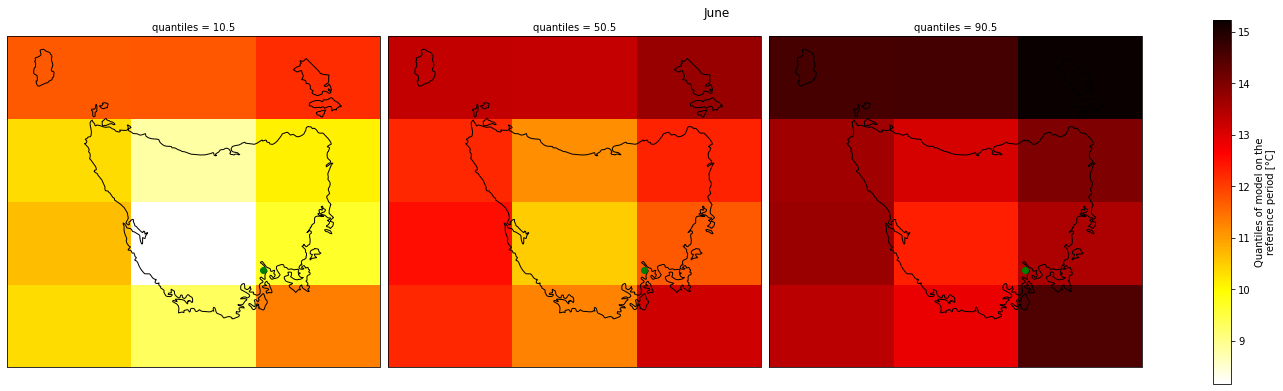

In [26]:
if 'lat' in qq_mapping.ds.dims:
    quantile_spatial_plot(
        qq_mapping.ds['hist_q'],
        example_month,
        lat_bounds=[lat_min_obs, lat_max_obs],
        lon_bounds=[lon_min_obs, lon_max_obs],
        example_point=example_point,
        cmap='hot_r',
    )

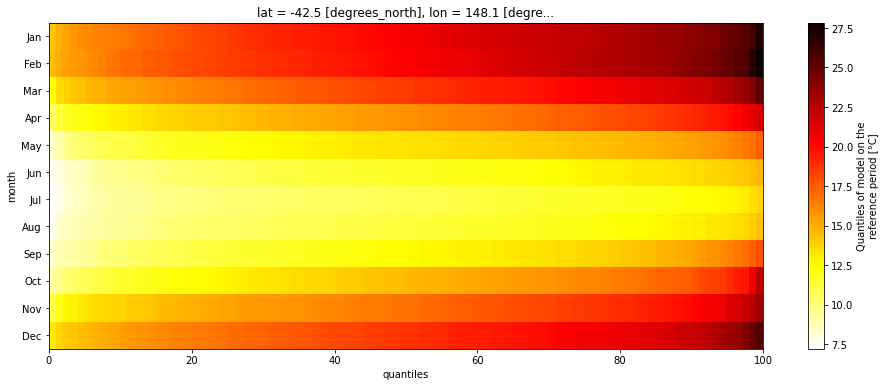

In [27]:
quantile_month_plot(qq_mapping.ds['hist_q'], cmap='hot_r', point=example_point)

In [28]:
qq_mapping.ds['af']

<xarray.DataArray 'af' (quantiles: 100, month: 12, lat: 145, lon: 192)>
array([[[[ 1.02273941e+00,  1.02273941e+00,  1.02273941e+00, ...,
           1.01774597e+00,  1.01774597e+00,  1.01774597e+00],
         [ 2.91271210e-01,  3.25668335e-01,  3.54988098e-01, ...,
           2.15332031e-01,  2.14885712e-01,  2.43598938e-01],
         [ 1.59034729e-02,  5.94673157e-02,  1.10832214e-01, ...,
           9.21974182e-02,  1.02077484e-01,  7.86476135e-02],
         ...,
         [ 3.57881546e+00,  3.64996338e+00,  3.48257446e+00, ...,
           3.75357819e+00,  3.81137085e+00,  3.85863495e+00],
         [ 3.12276077e+00,  3.08337402e+00,  3.03149033e+00, ...,
           3.27622604e+00,  3.26162338e+00,  3.18132401e+00],
         [ 3.52148056e+00,  3.52148056e+00,  3.52148056e+00, ...,
           3.52148056e+00,  3.52148056e+00,  3.52148056e+00]],

        [[ 3.08032990e-01,  3.08032990e-01,  3.08032990e-01, ...,
           3.04237366e-01,  3.04237366e-01,  3.04237366e-01],
         [ 1.16242218e+00,  1.09769058e+00,  1.00433350e+00, ...,
           1.21752930e+00,  1.20428848e+00,  1.17882156e+00],
         [ 4.10804749e-01,  4.11174774e-01,  3.69426727e-01, ...,
           5.90244293e-01,  5.47275543e-01,  3.90445709e-01],
...
           1.24329650e+00,  1.08392274e+00,  7.97353685e-01],
         [ 1.37530804e-01,  1.15993857e-01,  3.23691368e-02, ...,
           2.50352740e-01,  2.16516018e-01,  1.76259279e-01],
         [ 1.71843719e+00,  1.71843719e+00,  1.71843719e+00, ...,
           1.71843719e+00,  1.71843719e+00,  1.71843719e+00]],

        [[ 9.29088593e-01,  9.29088593e-01,  9.29088593e-01, ...,
           9.20155525e-01,  9.20155525e-01,  9.20155525e-01],
         [ 3.15273285e-01,  3.33244324e-01,  3.98035049e-01, ...,
           1.69036865e-01,  2.30743408e-01,  2.51716614e-01],
         [ 1.22991467e+00,  1.46189785e+00,  1.77363491e+00, ...,
           9.43224907e-01,  9.68945503e-01,  1.05793190e+00],
         ...,
         [-1.83271384e+00, -1.76495385e+00, -1.87339652e+00, ...,
          -1.12208366e+00, -1.59968209e+00, -1.80385613e+00],
         [-1.77716422e+00, -1.82331300e+00, -1.69771147e+00, ...,
          -1.84146643e+00, -1.81107688e+00, -1.76994848e+00],
         [-7.99239397e-01, -7.99239397e-01, -7.99239397e-01, ...,
          -7.99239397e-01, -7.99239397e-01, -7.99239397e-01]]]],
      dtype=float32)
Coordinates:
  * quantiles  (quantiles) float32 0.5 1.5 2.5 3.5 4.5 ... 96.5 97.5 98.5 99.5
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:     Adjustment factors
    long_name:         Quantile mapping adjustment factors
    units:             °C
    cell_methods:      time: maximum
    cell_measures:     area: areacella
    history:           2012-04-03T07:15:04Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...
    kind:              +

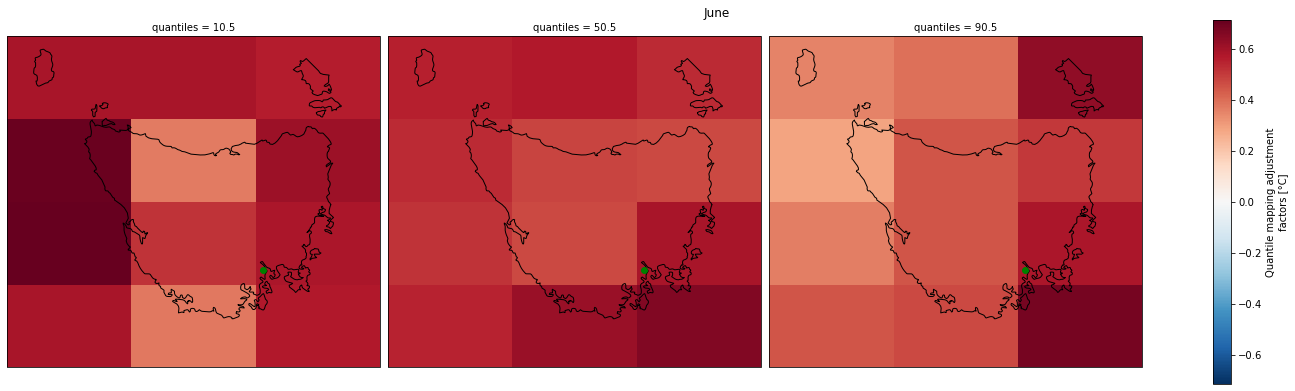

In [39]:
if 'lat' in qq_mapping.ds.dims:
    quantile_spatial_plot(
        qq_mapping.ds['af'],
        example_month,
        lat_bounds=[lat_min_obs, lat_max_obs],
        lon_bounds=[lon_min_obs, lon_max_obs],
        example_point=example_point,
        cmap='RdBu_r',
        diverging=True,
    )

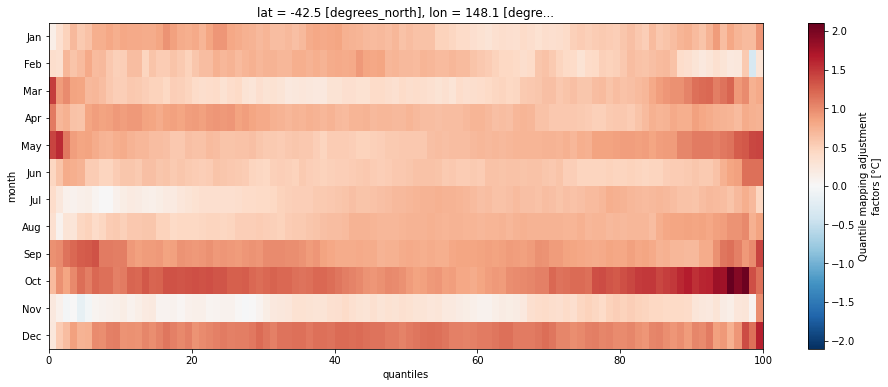

In [44]:
quantile_month_plot(qq_mapping.ds['af'], cmap='RdBu_r', point=example_point, diverging=True)

## QQ-scaled projections

In [45]:
if 'lat' in qq_mapping.ds.dims:
    regridder = xe.Regridder(ds_hist, ds_obs, "bilinear")
    qq_mapping.ds = regridder(qq_mapping.ds)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [46]:
qq_mapping.ds['hist_q'].attrs['units'] = ds_hist[model_var].attrs['units']
qq_mapping.ds['af'].attrs['units'] = ds_hist[model_var].attrs['units']
ds_obs[obs_var], qq_mapping = check_units(ds_obs[obs_var], qq_mapping, obs_units, model_units, output_units)

In [47]:
qq_mapping.ds = qq_mapping.ds.compute()

In [48]:
qq_obs = qq_mapping.adjust(ds_obs[obs_var], extrapolation="constant", interp="linear")
qq_obs = qq_obs.rename(variable)
if 'lat' in qq_obs.dims:
    qq_obs = qq_obs.transpose('time', 'lat', 'lon')
time_adjustment = ds_future['time'].values[0] - qq_obs['time'].values[0]
qq_obs = qq_obs.assign_coords({'time': qq_obs['time'].values + time_adjustment})

qq_obs

<xarray.DataArray 'tasmax' (time: 7305, lat: 91, lon: 111)>
dask.array<transpose, shape=(7305, 91, 111), dtype=float32, chunksize=(7305, 91, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -44.0 -43.95 -43.9 -43.85 ... -39.6 -39.55 -39.5
  * lon      (lon) float64 143.5 143.5 143.6 143.6 ... 148.9 148.9 149.0 149.0
  * time     (time) datetime64[ns] 2021-01-01T12:00:00 ... 2040-12-31T12:00:00
Attributes:
    cell_methods:                  time: maximum
    units:                         °C
    analysis_version_number:       3.51
    long_name:                     Daily maximum air temperature
    number_of_stations_reporting:  564
    standard_name:                 air_temperature
    frequency:                     daily
    length_scale_for_analysis:     250.0
    grid_mapping:                  crs
    coverage_content_type:         physicalMeasurement
    valid_range:                   [-100.  100.]
    history:                       [2022-05-13 11:58:48] : Bias-adjusted with...
    bias_adjustment:               EmpiricalQuantileMapping(group=Grouper(add...

In [51]:
#%whos

In [52]:
#del(ds_hist)
#del(ds_future)
#gc.collect()

In [53]:
#%whos

In [54]:
qq_obs.attrs['history'] = cmdprov.new_log()
qq_obs.to_netcdf(output_file)

[########################################] | 100% Completed |  9min  2.3s
[########################################] | 100% Completed |  9min  2.3s


In [55]:
qq_obs = qq_obs.compute()

[########################################] | 100% Completed |  8min 25.1s
[########################################] | 100% Completed |  8min 25.2s


In [84]:

def spatial_projections_plot(da_hist, da_future, da_obs, da_qq, lat_bounds, lon_bounds, title):
    """Plot model and QQ-scaled projections side-by-side"""

    lat_min, lat_max = lat_bounds
    lon_min, lon_max = lon_bounds
    model_sel = {'lat': slice(lat_min, lat_max), 'lon': slice(lon_min, lon_max)}
    hist_clim = da_hist.sel(model_sel).mean('time', keep_attrs=True)
    future_clim = da_future.sel(model_sel).mean('time', keep_attrs=True)
    model_change = future_clim - hist_clim

    obs_clim = da_obs.mean('time', keep_attrs=True)
    qq_clim = da_qq.mean('time', keep_attrs=True)
    qq_change = qq_clim - obs_clim

    model_abs_max = np.max(np.abs(model_change.values))
    qq_abs_max = np.max(np.abs(qq_change.values))
    abs_max = np.max([model_abs_max, qq_abs_max])
    vmax = abs_max
    vmin = -1 * abs_max

    fig = plt.figure(figsize=[16, 6])

    ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
    model_change.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        vmax=vmax,
        vmin=vmin
    )
    ax1.set_title('Original')

    ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
    qq_change.plot(
        ax=ax2,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        vmax=vmax,
        vmin=vmin
    )
    ax2.set_title('QQ-scaled')

    for ax in [ax1, ax2]:
        ax.coastlines()
        if example_point:
            lat, lon = example_point
            ax.plot(lon, lat, 'go', zorder=5, transform=ccrs.PlateCarree())
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

    plt.suptitle(title)
    plt.show()

[########################################] | 100% Completed |  1min 44.0s
[########################################] | 100% Completed |  1min 44.0s
[########################################] | 100% Completed |  1min 38.9s
[########################################] | 100% Completed |  1min 39.0s


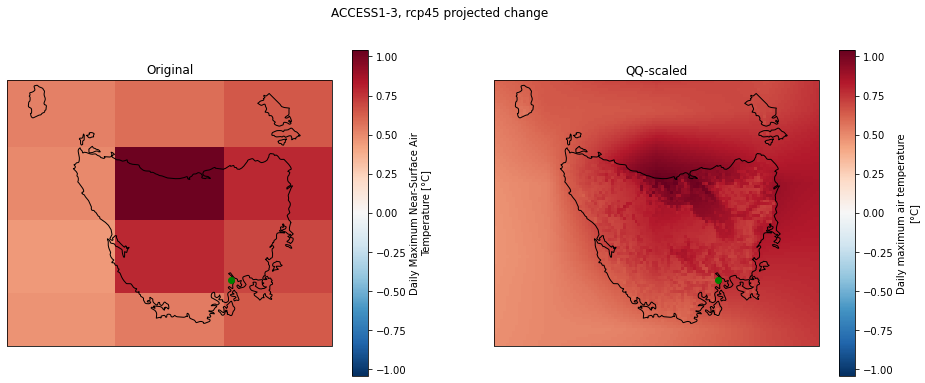

In [85]:
if 'lat' in qq_obs.dims:
    spatial_projections_plot(
        ds_hist[model_var],
        ds_future[model_var],
        ds_obs[obs_var],
        qq_obs,
        [lat_min_obs, lat_max_obs],
        [lon_min_obs, lon_max_obs],
        f'{model_name}, {future_scenario} projected change'
    )

[########################################] | 100% Completed |  1min 45.6s
[########################################] | 100% Completed |  1min 45.7s


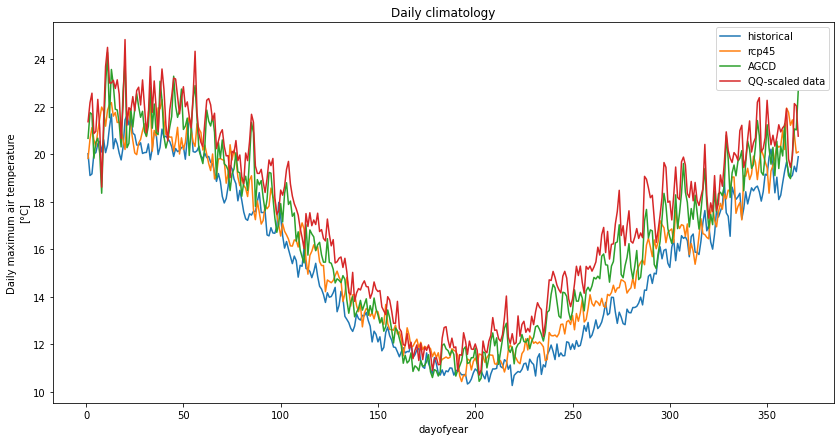

In [60]:
fig, ax = plt.subplots(figsize=[14, 7])
if 'lat' in qq_obs.dims:
    example_lat, example_lon = example_point
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
ds_hist[model_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="historical")
ds_future[model_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label=future_scenario)
ds_obs[obs_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label=obs_name)
qq_obs.sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="QQ-scaled data")
plt.legend()
plt.title('Daily climatology')
plt.show()

[########################################] | 100% Completed |  1min 37.1s
[########################################] | 100% Completed |  1min 37.2s


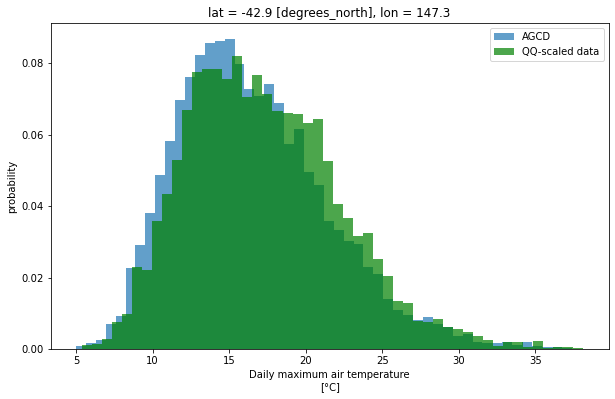

In [62]:
fig = plt.figure(figsize=[10, 6])
if 'lat' in qq_obs.dims:
    example_lat, example_lon = example_point
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
ds_obs[obs_var].sel(point_selection, method='nearest').plot.hist(bins=50, density=True, label=obs_name, alpha=0.7)
qq_obs.sel(point_selection, method='nearest').plot.hist(bins=50, density=True, label='QQ-scaled data', facecolor='green', alpha=0.7)
plt.ylabel('probability')
plt.legend()
plt.show()